## Imports

In [1]:
from scenarionet import read_dataset_summary, read_scenario
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from scipy.interpolate import interp1d


ModuleNotFoundError: No module named 'scenarionet'

## Nuscenes

##### Read dataset summary

In [ ]:
read_dataset_summary?

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/nuscenes_mini_converted_10/')

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0061.pkl']['sample_rate']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0061.pkl']['ts']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0061.pkl']['coordinate']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-1100.pkl']['sdc_id']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-1100.pkl']['id']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0061.pkl']['number_summary']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0553.pkl']['number_summary']

In [ ]:
dataset_summary['sd_nuscenes_v1.0-mini_scene-0553.pkl']['object_summary']

In [ ]:
read_scenario?

In [ ]:
mapping

In [ ]:
scenario = read_scenario(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/nuscenes_mini_converted_10/', mapping=mapping, scenario_file_name='sd_nuscenes_v1.0-mini_scene-0061.pkl')

###### 'scenario' important keys : 'length', 'metadata', 'tracks', 'map_features'

In [ ]:
scenario.keys()

In [ ]:
scenario['length']

###### 'metadata' key has a dict value which is the same as dataset_summary
###### 'metadata' important keys : 'ts', 'object_summary', 'number_summary'

In [ ]:
scenario['metadata'].keys()

In [ ]:
scenario['metadata']['ts'].shape

In [ ]:
scenario['metadata']['object_summary']

In [ ]:
scenario['metadata']['number_summary']

###### scenario 'track' key

###### ['tracks']['(id)'] important keys : 'type', 'state'

In [ ]:
len(scenario['tracks'].keys())

###### len(scenario['tracks'].keys()) == to the number of objects in the scenario

In [ ]:
len(scenario['tracks'].keys())

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269'].keys()

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['type']

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['metadata']

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state'].keys()

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['position'].shape

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['heading'].shape

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['velocity'].shape

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['valid'].shape

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['length'].shape

In [ ]:
scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['width'].shape

In [ ]:
type(scenario['tracks']['1511e02cbd80490299371149ed7eb269']['state']['height'])

##### Agent features 
Numpy array file representing per scenario of shape (num_agents, seq_length, dim) where dim is an array representing [valid, x, y, h, Vx, Vy, W, L] and seq_length is the length of the scenario and more precisely the length of the ts array.'

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')

list_seq_length, list_num_ped, list_num_cyc, list_num_veh = [], [], [], []
for sc in scenario_ids:
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc)
    seq_length = scenario['length']
    
    list_seq_length.append(seq_length)
    print('seq_length: ', seq_length)
    
    #print('shape of ts: ', scenario['metadata']['ts'].shape)

    scenario_ped_list = []
    scenario_cyc_list = []
    scenario_veh_list = []
    for agent in scenario['tracks'].keys():
        if scenario['tracks'][agent]['type'] in ['PEDESTRIAN']:
            state_dict = scenario['tracks'][agent]['state']
            ts = scenario['metadata']['ts']  #-- array of shape (seq_length,)
            vd = state_dict['valid']         #-- array of shape (seq_length,) (either 0. or 1.)
            p  = state_dict['position']      #-- array of shape (seq_length, 3)
            hd = state_dict['heading']       #-- array of shape (seq_length,)
            v  = state_dict['velocity']      #-- array of shape (seq_length, 2)
            h  = state_dict['height']        #-- array of shape (seq_length, 1)
            w  = state_dict['width']         #-- array of shape (seq_length, 1)
            l  = state_dict['length']        #-- array of shape (seq_length, 1)
            agent_list = []
            for s in range(seq_length):
                agent_list.append([p[s][0], p[s][1]])
            scenario_ped_list.append(agent_list)
            
        elif scenario['tracks'][agent]['type'] in ['CYCLIST']:
            state_dict = scenario['tracks'][agent]['state']
            ts = scenario['metadata']['ts']  #-- array of shape (seq_length,)
            vd = state_dict['valid']         #-- array of shape (seq_length,) (either 0. or 1.)
            p  = state_dict['position']      #-- array of shape (seq_length, 3)
            hd = state_dict['heading']       #-- array of shape (seq_length,)
            v  = state_dict['velocity']      #-- array of shape (seq_length, 2)
            h  = state_dict['height']        #-- array of shape (seq_length, 1)
            w  = state_dict['width']         #-- array of shape (seq_length, 1)
            l  = state_dict['length']        #-- array of shape (seq_length, 1)
            agent_list = []
            for s in range(seq_length):
                agent_list.append([p[s][0], p[s][1]])
            scenario_cyc_list.append(agent_list)
        
        elif scenario['tracks'][agent]['type'] in ['VEHICLE']:
            state_dict = scenario['tracks'][agent]['state']
            ts = scenario['metadata']['ts']  #-- array of shape (seq_length,)
            vd = state_dict['valid']         #-- array of shape (seq_length,) (either 0. or 1.)
            p  = state_dict['position']      #-- array of shape (seq_length, 3)
            hd = state_dict['heading']       #-- array of shape (seq_length,)
            v  = state_dict['velocity']      #-- array of shape (seq_length, 2)
            h  = state_dict['height']        #-- array of shape (seq_length, 1)
            w  = state_dict['width']         #-- array of shape (seq_length, 1)
            l  = state_dict['length']        #-- array of shape (seq_length, 1)
            agent_list = []
            for s in range(seq_length):
                agent_list.append([p[s][0], p[s][1]])
            scenario_veh_list.append(agent_list)
            
    list_num_ped.append(len(scenario_ped_list))
    list_num_cyc.append(len(scenario_cyc_list))
    list_num_veh.append(len(scenario_veh_list))

    scenario_ped_npy = np.array(scenario_ped_list)
    scenario_ped_npy = scenario_ped_npy[:, :40, :]
    print(scenario_ped_npy.shape)
    dir_ped_path = '/data/tii/data/nuscenes_trainval_ped_npy/'
    os.makedirs(dir_ped_path, exist_ok=True)
    full_path = os.path.join(dir_ped_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, scenario_ped_npy)
    
    '''
    scenario_cyc_npy = np.array(scenario_cyc_list)
    scenario_cyc_npy = scenario_cyc_npy[:, :40, :]
    print(scenario_cyc_npy.shape)
    dir_cyc_path = '/data/tii/data/nuscenes_trainval_cyc_npy/'
    os.makedirs(dir_cyc_path, exist_ok=True)
    full_path = os.path.join(dir_cyc_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, scenario_cyc_npy)
    '''
    scenario_veh_npy = np.array(scenario_veh_list)
    scenario_veh_npy = scenario_veh_npy[:, :40, :]    
    print(scenario_veh_npy.shape)
    dir_veh_path = '/data/tii/data/nuscenes_trainval_veh_npy/'
    os.makedirs(dir_veh_path, exist_ok=True)
    full_path = os.path.join(dir_veh_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, scenario_veh_npy)
    
    print(f'Scenario {sc} saved !')

print('max seq_length: ', max(list_seq_length))
print('min seq_length: ', min(list_seq_length))
print(f'max number of PED: {max(list_num_ped)}, and min number of PED: {min(list_num_ped)}')
print(f'max number of CYC: {max(list_num_cyc)}, and min number of CYC: {min(list_num_cyc)}')
print(f'max number of VEH: {max(list_num_veh)}, and min number of VEH: {min(list_num_veh)}')


In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')

list_seq_length, list_num_agents = [], []
for sc in scenario_ids:
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc)
    seq_length = scenario['length']
    
    list_seq_length.append(seq_length)
    print('seq_length: ', seq_length)
    
    #print('shape of ts: ', scenario['metadata']['ts'].shape)

    scenario_list = []
    for agent in scenario['tracks'].keys():
        #if scenario['tracks'][agent]['type'] in ['PEDESTRIAN', 'CYCLIST', 'VEHICLE']:
        if scenario['tracks'][agent]['type'] in ['VEHICLE']:
            state_dict = scenario['tracks'][agent]['state']
            
            ts = scenario['metadata']['ts']  #-- array of shape (seq_length,)
            vd = state_dict['valid']         #-- array of shape (seq_length,) (either 0. or 1.)
            p  = state_dict['position']      #-- array of shape (seq_length, 3)
            hd = state_dict['heading']       #-- array of shape (seq_length,)
            v  = state_dict['velocity']      #-- array of shape (seq_length, 2)
            h  = state_dict['height']        #-- array of shape (seq_length, 1)
            w  = state_dict['width']         #-- array of shape (seq_length, 1)
            l  = state_dict['length']        #-- array of shape (seq_length, 1)
            
            agent_list = []
            for s in range(seq_length):
                # [Nuscenes paper] Data annotation. ... a cuboid modeled as x, y, z, width, length, height
                #print(f'Position vector: ({p[s][0]}, {p[s][1]})')
                agent_list.append([p[s][0], p[s][1]])
                #agent_list.append([ts[s], p[s][0], p[s][1]])
                #agent_list.append([vd[s], p[s][0], p[s][1], hd[s], v[s][0], v[s][1], w[s][0], l[s][0]])
                #agent_list.append([vd[s], ts[s], p[s][0], p[s][1], p[s][2], hd[s], v[s][0], v[s][1], h[s][0], w[s][0], l[s][0]])
            
            scenario_list.append(agent_list)
            
    list_num_agents.append(len(scenario_list))

    scenario_npy = np.array(scenario_list)
    # truncate the numpy array to the min seq_length: 156 for a fixed seq_length
    scenario_npy = scenario_npy[:, :156, :]
    print(scenario_npy.shape)

    dir_path = '/data/tii/data/nuscenes_trainval_veh_npy/'
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, scenario_npy)
    print(f'Scenario {sc} saved !')

print('max seq_length: ', max(list_seq_length))
print('min seq_length: ', min(list_seq_length))
print('max number of agents: ', max(list_num_agents))
print('min number of agents: ', min(list_num_agents))

##### Map features

###### Visualize map feature types through all scenarios in nuscenes trainval and mini: ['ROAD_LINE_SOLID_SINGLE_WHITE', 'ROAD_LINE_BROKEN_SINGLE_WHITE', 'ROAD_LINE_SOLID_SINGLE_YELLOW', 'CROSSWALK', 'ROAD_EDGE_SIDEWALK', 'LANE_SURFACE_STREET', 'LANE_SURFACE_UNSTRUCTURE']


In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')

l_type = []
for sc in scenario_ids:
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc)
    print('scenario: ', sc)
    print(len(scenario['map_features'].keys()))

    for k in scenario['map_features'].keys():
        ft_type = scenario['map_features'][k]['type']
        #print(k)
        if ft_type not in l_type:
            l_type.append(ft_type)
    
print('map feature types through all scenarios in nuscenes trainval:', l_type)

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl')

scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl', mapping=mapping, scenario_file_name='sd_nuscenes_v1.0-trainval_scene-0001.pkl')

tracks = scenario['tracks']
num_agents = len(tracks.keys())
colors = cm.rainbow(np.linspace(0, 1, num_agents))

plt.figure()
max_x, max_y = 0., 0.
for idx, (id, track) in enumerate(tracks.items()):
    print(id)
    xyz = track['state']['position']  #-- array of shape (seq_length, 3)
    print(xyz.shape)
    
    # Filter out invalid points
    valid_points = xyz[(xyz[:, 0] != 0.0) & (xyz[:, 1] != 0.0)]
    
    if valid_points.shape[0] > 0:
        if max(valid_points[:, 0]) > max_x:
            max_x = max(valid_points[:, 0])
        if max(valid_points[:, 1]) > max_y:
            max_y = max(valid_points[:, 1])
            
        plt.plot(valid_points[:, 0], valid_points[:, 1], color=colors[idx], label=f'Agent {id}')

    
print(f'{max_x+10, max_y+10}')
# Remove axes
#plt.axis('off')
output_file_path = './tracks_sd_nuscenes_v1.0-mini_scene-0103.png'
plt.savefig(output_file_path, format='png')

In [ ]:
# Initialize the plot
# only polylines
plt.figure(figsize=(10, 10))

for k in scenario['map_features'].keys():
    if scenario['map_features'][k]['type'] in ['CROSSWALK', 'ROAD_EDGE_SIDEWALK']:
        for kk in scenario['map_features'][k].keys():
            if kk in 'polyline':
                polyline_arr = scenario['map_features'][k][kk]
                # Plot the polyline
                plt.plot(polyline_arr[:, 0], polyline_arr[:, 1], color='k')
            elif kk == 'polygon':
                polygon_arr = scenario['map_features'][k][kk]
                # Plot the polygon
                plt.plot(polygon_arr[:, 0], polygon_arr[:, 1], color='k')
            
# Remove axes
plt.axis('off')
output_file_path = './PED.png'
plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0, transparent=False, format='png')

In [ ]:
# Initialize the plot
# only polylines
plt.figure(figsize=(10, 10))

for k in scenario['map_features'].keys():
    if scenario['map_features'][k]['type'] in ['LANE_SURFACE_STREET', 'LANE_SURFACE_UNSTRUCTURE', 'ROAD_LINE_SOLID_SINGLE_WHITE', 'ROAD_LINE_SOLID_SINGLE_YELLOW', 'ROAD_LINE_BROKEN_SINGLE_WHITE']:
        for kk in scenario['map_features'][k].keys():
            if kk == 'polyline':
                polyline_arr = scenario['map_features'][k][kk]
                # Plot the polyline
                plt.plot(polyline_arr[:, 0], polyline_arr[:, 1], color='k')
            elif kk == 'polygon':
                polygon_arr = scenario['map_features'][k][kk]
                # Plot the polygon
                plt.plot(polygon_arr[:, 0], polygon_arr[:, 1], color='k')
            
# Remove axes
#plt.axis('off')
output_file_path = './VEH_CYC.png'
plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0, transparent=False, format='png')

In [ ]:
# Initialize the plot
# only polylines
plt.figure(figsize=(100, 100))

for k in scenario['map_features'].keys():
    if scenario['map_features'][k]['type'] in ['ROAD_LINE_BROKEN_SINGLE_WHITE', 'ROAD_LINE_SOLID_SINGLE_YELLOW', 'LANE_SURFACE_STREET', 'LANE_SURFACE_UNSTRUCTURE']:
        for kk in scenario['map_features'][k].keys():
            if kk == 'polyline':
                polyline_arr = scenario['map_features'][k][kk]
                # Plot the polyline
                plt.plot(polyline_arr[:, 0], polyline_arr[:, 1])
            elif kk == 'polygon':
                polygon_arr = scenario['map_features'][k][kk]
                # Plot the polygon
                plt.plot(polygon_arr[:, 0], polygon_arr[:, 1])

tracks = scenario['tracks']
#num_agents = len(tracks.keys())
#colors = cm.rainbow(np.linspace(0, 1, num_agents))


for idx, (id, track) in enumerate(tracks.items()):
    #print(id)
    #-- ('PEDESTRIAN', 'CYCLIST', 'TRAFFIC_CONE', 'TRAFFIC_BARRIER', 'VEHICLE')

    if track['type'] in ['CYCLIST', 'VEHICLE']:
        xyz = track['state']['position']  #-- array of shape (seq_length, 3)
        #print(xyz.shape)
        
        # Filter out invalid points
        valid_points = xyz[(xyz[:, 0] != 0.0) & (xyz[:, 1] != 0.0)]
        
        if valid_points.shape[0] > 0:
            #plt.plot(valid_points[:, 0], valid_points[:, 1], color=colors[idx], label=f'Agent {id}')
            plt.plot(valid_points[:, 0], valid_points[:, 1], color='k', label=f'Agent {id}')
        

# Remove axes
plt.axis('off')
output_file_path = './VEH_CYC_TRAJ.png'
plt.savefig(output_file_path, bbox_inches='tight', pad_inches=0, transparent=False, format='png')

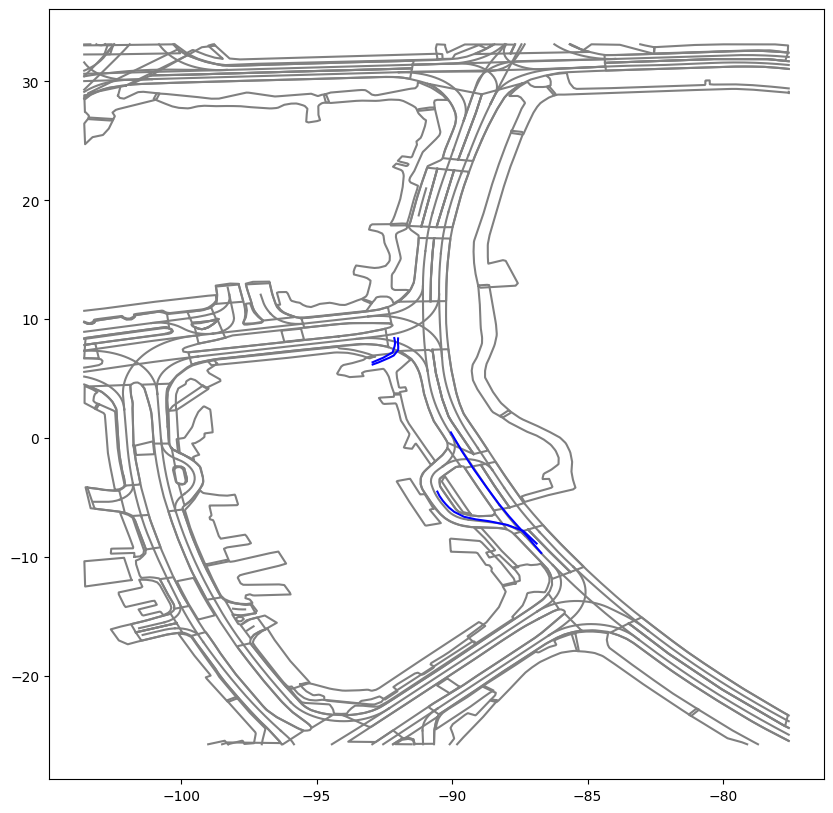

In [31]:
map1 = np.load('/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy/sd_nuscenes_v1.0-trainval_scene-0160.npy')
data1 = np.load('/data/tii/data/nuscenes_trainval_clean_train/sd_nuscenes_v1.0-trainval_scene-0160.npy')
plt.figure(figsize=(10, 10))

for ag in range(map1.shape[0]):
    agent_traj = map1[ag, :, :]
    plt.plot(agent_traj[:, 0], agent_traj[:, 1], color='gray')

for ag in range(data1.shape[0]):
    agent_traj = data1[ag, :, :]
    valid_xy = agent_traj[(agent_traj[:, 0] != 0.0) & (agent_traj[:, 1] != 0.0)]
    plt.plot(valid_xy[:, 0], valid_xy[:, 1], color='b')
    
plt.show() 

###### Map features to png files

In [ ]:
# Define the input and output directories
input_dir = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_png'  

'''
# Process each file in the input directory
for filename in os.listdir(input_dir):
        # Open the image
        img_path = os.path.join(input_dir, filename)
        image = Image.open(img_path)

        # Convert RGBA to RGB
        rgb_image = image.convert('RGB')

        # Convert to NumPy array for cropping
        np_image = np.array(rgb_image)

        # Crop 1 pixel from height and width
        cropped_image = np_image[:-1, :-1, :]

        # Convert back to a PIL image
        cropped_pil_image = Image.fromarray(cropped_image)

        # Save the processed image to the output directory
        output_path = os.path.join(input_dir, filename)
        cropped_pil_image.save(output_path)
        print('Cropped array shape:', cropped_image.shape)
        print('Cropped array values in (128, 100):', cropped_image[128][100])
        print(f"Processed and saved {filename}")

print("All images processed.")
#'''

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')

for sc in scenario_ids:
    plt.figure(figsize=(2.87, 2.87))
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc) 

    for k in scenario['map_features'].keys():
        if scenario['map_features'][k]['type'] in ['ROAD_LINE_BROKEN_SINGLE_WHITE', 'ROAD_LINE_SOLID_SINGLE_YELLOW', 'LANE_SURFACE_STREET', 'LANE_SURFACE_UNSTRUCTURE']:
            for kk in scenario['map_features'][k].keys():
                if kk in ['polyline', 'polygon']:
                    poly_arr = scenario['map_features'][k][kk]
                    # Plot the polyline/polygon
                    plt.plot(poly_arr[:, 0], poly_arr[:, 1], color='b')
        elif scenario['map_features'][k]['type'] in ['ROAD_EDGE_SIDEWALK', 'CROSSWALK']:
            for kk in scenario['map_features'][k].keys():
                if kk in ['polyline', 'polygon']:
                    poly_arr = scenario['map_features'][k][kk]
                    # Plot the polyline/polygon
                    plt.plot(poly_arr[:, 0], poly_arr[:, 1], color='g')
        elif scenario['map_features'][k]['type'] == 'ROAD_LINE_SOLID_SINGLE_WHITE':
            for kk in scenario['map_features'][k].keys():
                if kk in ['polyline', 'polygon']:
                    poly_arr = scenario['map_features'][k][kk]
                    # Plot the polyline/polygon
                    plt.plot(poly_arr[:, 0], poly_arr[:, 1], color='r')

                
    # Remove axes
    plt.axis('off')
    
    # Ensure the layout is correct before saving
    plt.tight_layout()
    
    dir_path = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_png3/'
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, sc)
    new_file_path = full_path.replace('.pkl', '.png')
    
    #print("Figure size before saving:", fig.get_size_inches())
    plt.savefig(new_file_path, bbox_inches='tight', pad_inches=0, transparent=False, format='png')

    print(f'Map of the scenario {sc} saved in png format!')
    plt.close()



In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')

for sc in scenario_ids:
    plt.figure(figsize=(2.87, 2.87))
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc) 

    for k in scenario['map_features'].keys():
        if scenario['map_features'][k]['type'] != 'ROAD_LINE_SOLID_SINGLE_WHITE':
            for kk in scenario['map_features'][k].keys():
                if kk in ['polyline', 'polygon']:
                    poly_arr = scenario['map_features'][k][kk]
                    # Plot the polyline/polygon
                    plt.plot(poly_arr[:, 0], poly_arr[:, 1])
                
    # Remove axes
    plt.axis('off')
    
    # Ensure the layout is correct before saving
    plt.tight_layout()
    
    dir_path = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_png/'
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, sc)
    new_file_path = full_path.replace('.pkl', '.png')
    
    #print("Figure size before saving:", fig.get_size_inches())
    plt.savefig(new_file_path, bbox_inches='tight', pad_inches=0, transparent=False, format='png')

    print(f'Map of the scenario {sc} saved in png format!')
    plt.close()

###### Map features to npy files

In [ ]:
def interpolate_to_fixed_length(trajectory, num_timesteps, kind):
    """
    Interpolate a variable-length trajectory to a fixed number of timesteps.

    Parameters:
    trajectory (np.ndarray): Input trajectory of shape (L, 2), where L is the number of timesteps.
    num_timesteps (int): The number of timesteps to interpolate to (default is 10).
    kind: choose from 'linear', 'quadratic', 'cubic'.
    Returns:
    np.ndarray: Interpolated trajectory of shape (num_timesteps, 2).
    """
    L = trajectory.shape[0]  # Original length of the trajectory

    # Original timesteps
    original_timesteps = np.linspace(0, L - 1, L)

    # New timesteps to interpolate to
    new_timesteps = np.linspace(0, L - 1, num_timesteps)

    # Interpolated trajectory
    interpolated_trajectory = np.zeros((num_timesteps, 2))

    # Interpolate x and y separately
    for i in range(2):  # for each dimension x and y
        interp_func = interp1d(original_timesteps, trajectory[:, i], kind=kind, fill_value='extrapolate')
        interpolated_trajectory[:, i] = interp_func(new_timesteps)

    return interpolated_trajectory


def slice_array_based_on_condition(arr, epsilon):
    slices = []
    start_idx = 0

    # Iterate through the array to find break points
    for i in range(len(arr) - 1):
        x_diff = abs(arr[i, 0] - arr[i + 1, 0])
        y_diff = abs(arr[i, 1] - arr[i + 1, 1])

        if x_diff > epsilon or y_diff > epsilon:
            # If the condition is met, slice the array
            slices.append(arr[start_idx:i+1])
            start_idx = i + 1

    # Add the last slice
    if start_idx < len(arr):
        slices.append(arr[start_idx:])
    
    return slices

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/tii/data/nuscenes_trainval_pkl/')
ft_list = []
for sc in scenario_ids[0]:
    print(f'Map of the scenario {sc} is being processed...')
    scenario = read_scenario(dataset_path='/data/tii/data/nuscenes_trainval_pkl/', mapping=mapping, scenario_file_name=sc)
    #plt.figure(figsize=(10, 10))
    
    # Determine the min max position of agents in the scenario 
    tracks = scenario['tracks']
    min_x, min_y = float('inf'), float('inf')
    max_x, max_y = 0., 0.
    for idx, (id, track) in enumerate(tracks.items()):
        xyz = track['state']['position']  #-- array of shape (seq_length, 3)
        # Filter out invalid points
        valid_points = xyz[(xyz[:, 0] != 0.0) & (xyz[:, 1] != 0.0)]
        if valid_points.shape[0] > 0:
            if max(valid_points[:, 0]) > max_x:
                max_x = max(valid_points[:, 0])
            if max(valid_points[:, 1]) > max_y:
                max_y = max(valid_points[:, 1])
            if min(valid_points[:, 0]) < min_x:
                min_x = min(valid_points[:, 0])
            if min(valid_points[:, 1]) < min_y:
                min_y = min(valid_points[:, 1])
        # plot the agents traj
        #plt.plot(valid_points[:, 0], valid_points[:, 1], color='b')

    # Crop the map feature of the scenario and filter undesired points 
    arr_list = []
    for k in scenario['map_features'].keys():
        for kk in scenario['map_features'][k].keys():
            if kk in ['polyline', 'polygon']:
                arr = scenario['map_features'][k][kk]
                arr = arr[:, :2]
                if arr.shape[0]>1 :
                    # interpolate 
                    arr = interpolate_to_fixed_length(arr, num_timesteps=50000, kind='linear')
                    # crop to max_x max_y
                    cropped_arr = arr[
                        (arr[:, 0] >= min_x - 50) & 
                        (arr[:, 0] <= max_x + 50) &
                        (arr[:, 1] >= min_y - 50) &
                        (arr[:, 1] <= max_y + 50)]
                    
                    if cropped_arr.shape[0] > 1:
                        # slice the cropped array to avoid weird cnx
                        cropped_arr_slices = slice_array_based_on_condition(cropped_arr, epsilon=50)
                        for arr_slice in cropped_arr_slices:
                            if arr_slice.shape[0] > 1:
                                # interpolate
                                arr_slice = interpolate_to_fixed_length(arr_slice, num_timesteps=128, kind='linear')
                                arr_list.append(arr_slice)
    
    arr_map = np.array(arr_list)
    print(f'Shape of the map array: {arr_map.shape}')
    ft_list.append(arr_map.shape[0])
    
    # plot the map
    #for idx in range(arr_map.shape[0]):
    #    plt.plot(arr_map[idx, :, 0], arr_map[idx, :, 1], color='gray')
    
    dir_path = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_npy/'
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, arr_map)
    print(f'Map of the scenario {sc} saved in npy format!\n')

print(max(ft_list)) 


###### Normalize and scale the npy Map features 

In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def normalize_and_standardize_excluding_padding(data, mean, std):
    """Normalize and standardize the positions x and y in the data, excluding zero padding."""
    mask = np.any(data != 0, axis=-1)
    normalized_standardized_data = np.copy(data)
    normalized_standardized_data[mask] = (data[mask] - mean) / std
    return normalized_standardized_data

def process_grouped_npy_files(input_directory, output_directory, mean, std):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        normalized_standardized_data = normalize_and_standardize_excluding_padding(data, mean, std)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, normalized_standardized_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_npy'
    output_directory = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy'
    
    mean = [1117.28378752, 1231.38483692]
    std = [600.29805033, 427.54111417]
    print(f'mean and std from padded trainval: (mean: {mean}, std: {std})')
    
    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, mean, std)

if __name__ == "__main__":
    main()

In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def process_grouped_npy_files(input_directory, output_directory, scale_factor):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        scaled_data = data * scale_factor
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, scaled_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy'
    output_directory = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy'

    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, scale_factor=100)

if __name__ == "__main__":
    main()

In [33]:
import os
import shutil

def move_matching_files(dir_A, dir_B, dir_D):
    """
    Move files from dir_A to dir_D where the filenames match those in dir_B.

    Parameters:
    dir_A (str): The source directory from which to move files.
    dir_B (str): The reference directory to check for matching filenames.
    dir_D (str): The destination directory where files will be moved.
    """

    # Ensure the destination directory exists
    os.makedirs(dir_D, exist_ok=True)

    # Get the set of filenames in dir_B
    files_in_B = set(os.listdir(dir_B))

    # Iterate over files in dir_A
    for filename in os.listdir(dir_A):
        if filename in files_in_B:
            # If a matching file is found, construct full paths
            source_path = os.path.join(dir_A, filename)
            destination_path = os.path.join(dir_D, filename)

            # Move the file from dir_A to dir_D
            shutil.move(source_path, destination_path)
            print(f"Moved: {filename} from {dir_A} to {dir_D}")

if __name__ == "__main__":
    dir_A = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy'  
    dir_B = '/data/tii/data/nuscenes_trainval_clean_test'  
    dir_D = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test'  

    move_matching_files(dir_A, dir_B, dir_D)

Moved: sd_nuscenes_v1.0-trainval_scene-0004.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test
Moved: sd_nuscenes_v1.0-trainval_scene-0007.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test
Moved: sd_nuscenes_v1.0-trainval_scene-0010.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test
Moved: sd_nuscenes_v1.0-trainval_scene-0013.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test
Moved: sd_nuscenes_v1.0-trainval_scene-0014.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test
Moved: sd_nuscenes_v1.0-trainval_scene-0015.npy from /data/tii/data/nuscenes_maps/nuscenes_trainval_maps_norm_npy to /data/tii/dat

## Waymo

##### Agent features

In [ ]:
import numpy as np
import os 
from scenarionet import read_dataset_summary, read_scenario


dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/waymo_converted_556/')

list_seq_length, list_num_agents = [], []
for sc in scenario_ids:
    scenario = read_scenario(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/waymo_converted_556/', mapping=mapping, scenario_file_name=sc)
    seq_length = scenario['length']
    
    list_seq_length.append(seq_length)
    print('seq_length: ', seq_length)
    
    #print('shape of ts: ', scenario['metadata']['ts'].shape)

    scenario_list = []
    for agent in scenario['tracks'].keys():
        if scenario['tracks'][agent]['type'] in ['PEDESTRIAN', 'CYCLIST', 'VEHICLE']:
            state_dict = scenario['tracks'][agent]['state']
            
            #ts = scenario['metadata']['ts']  #-- array of shape (seq_length,)
            vd = state_dict['valid']         #-- array of shape (seq_length,) (either False or True)
            vd = vd.astype(float)            #-- array of shape (seq_length,) (either 0. or 1.) ==> to match nuscenes vd type 
            p  = state_dict['position']      #-- array of shape (seq_length, 3)
            hd = state_dict['heading']       #-- array of shape (seq_length,)
            v  = state_dict['velocity']      #-- array of shape (seq_length, 2)
            h  = state_dict['height']        #-- array of shape (seq_length,)
            w  = state_dict['width']         #-- array of shape (seq_length,)
            l  = state_dict['length']        #-- array of shape (seq_length,)
            
            agent_list = []
            for s in range(seq_length):
                agent_list.append([vd[s], p[s][0], p[s][1], hd[s], v[s][0], v[s][1], w[s], l[s]])
                #agent_list.append([vd[s], p[s][0], p[s][1], p[s][2], hd[s], v[s][0], v[s][1], h[s], w[s], l[s]])
                #agent_list.append([vd[s], ts[s], p[s][0], p[s][1], p[s][2], hd[s], v[s][0], v[s][1], h[s], w[s], l[s]])
            
            scenario_list.append(agent_list)
    
    list_num_agents.append(len(scenario_list))

    scenario_npy = np.array(scenario_list)
    print('before slicing', scenario_npy.shape)
    # truncate the numpy array to the min seq_length: 91 to have a uniform shape in dim 1 and 2
    scenario_npy = scenario_npy[:, :91, :]
    print('after slicing', scenario_npy.shape)

    dir_path = '/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/waymo_556_npy/'
    os.makedirs(dir_path, exist_ok=True)
    full_path = os.path.join(dir_path, sc)
    new_file_path = full_path.replace('.pkl', '.npy')
    np.save(new_file_path, scenario_npy)
    print(f'Scenario {sc} saved !')

print('max seq_length: ', max(list_seq_length))
print('min seq_length: ', min(list_seq_length))
print('max number of agents: ', max(list_num_agents))
print('min number of agents: ', min(list_num_agents))


##### Map features

In [ ]:
dataset_summary, scenario_ids, mapping = read_dataset_summary(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/waymo_converted_556/')

scenario = read_scenario(dataset_path='/data/ahmed.ghorbel/workdir/autod/unitraj/mdsn/dataset/waymo_converted_556/', mapping=mapping, scenario_file_name='sd_waymo_v1.2_1a7c62ecf73896d8.pkl')

print(scenario['map_features'].keys())
print(len(scenario['map_features'].keys()))

## Data process

#### 1- Sample the sequence length to 13. 

#### 2- Normalize padded or not multi agent data 

#### 3- Scale the normalized dataset

#### 4- Remove stastionary agents from padded dataset

#### 5- Pad clean scenarios to max number of agents

#### 6- train test split

#### 0- Other

##### Plot npy and rasterized maps

sd_nuscenes_v1.0-trainval_scene-0004.npy


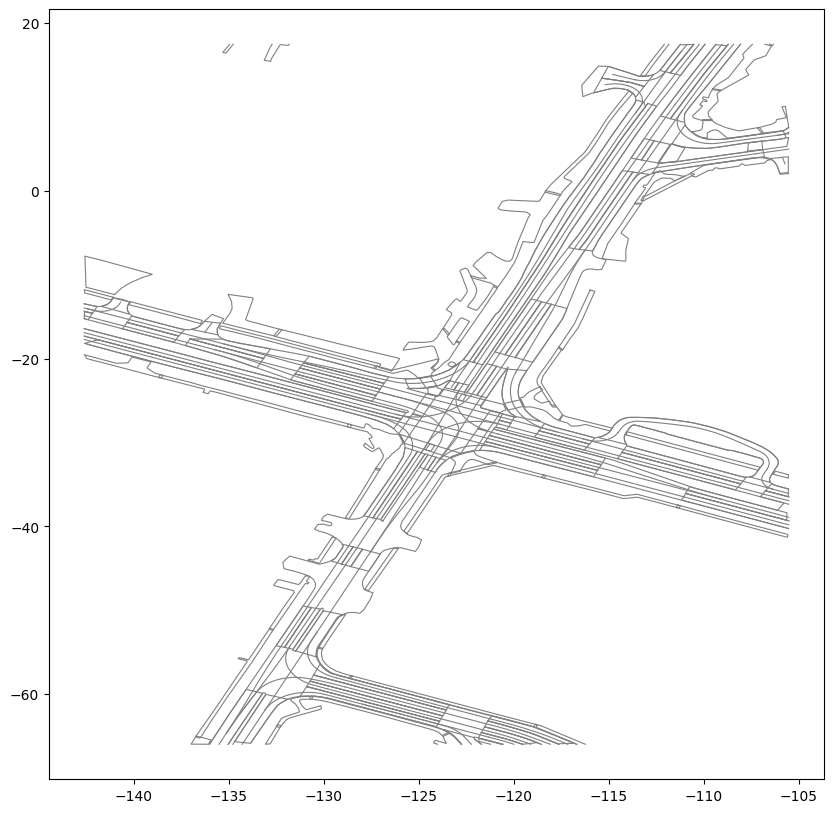

sd_nuscenes_v1.0-trainval_scene-0007.npy


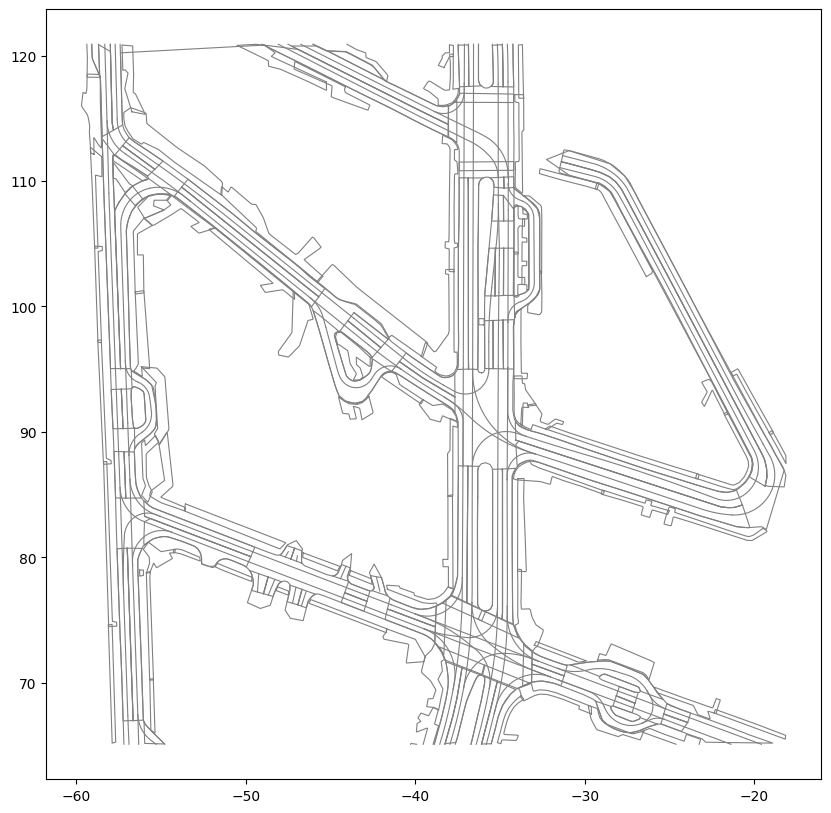

sd_nuscenes_v1.0-trainval_scene-0010.npy


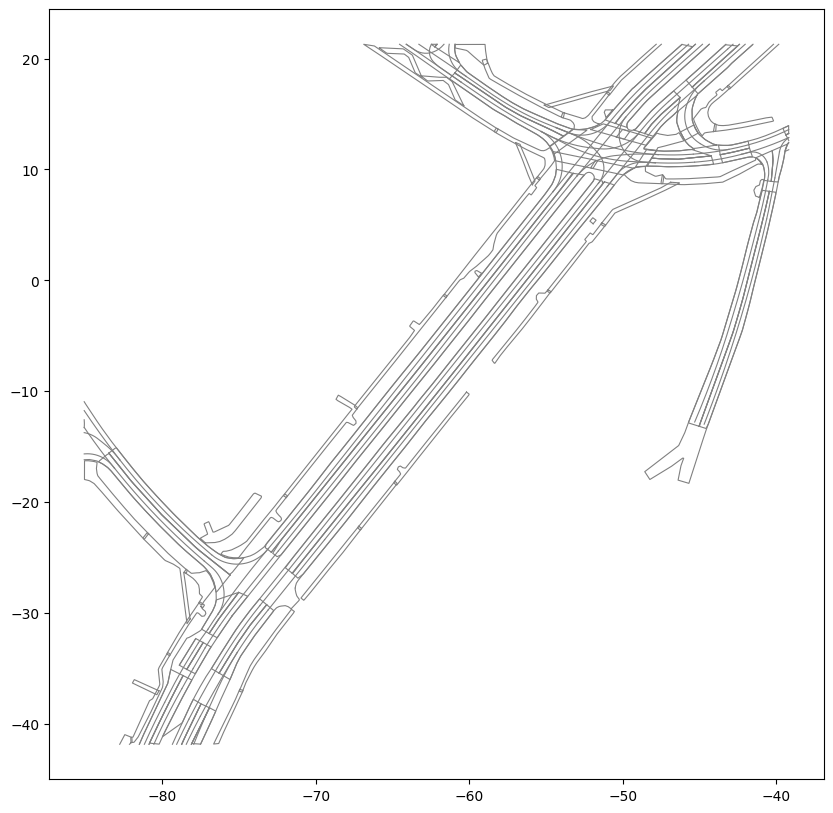

In [ ]:
map_dir = '/data/tii/data/nuscenes_maps/nuscenes_trainval_maps_test'
max_plots = 3
figsize = (10, 10)
for l in sorted(os.listdir(map_dir))[:max_plots]:
    print(l)
    data = np.load(os.path.join(map_dir, l))
    # Loop through each scene and plot separately
    plt.figure(figsize=figsize) 
    for ag in [i for i in range(data.shape[0])]:  # Loop through each agent in the scene   
        plt.plot(data[ag, :, 0], data[ag, :, 1], 'gray', linewidth=0.8)
    plt.show() 
    plt.close()  

sd_nuscenes_v1.0-trainval_scene-0004.npy


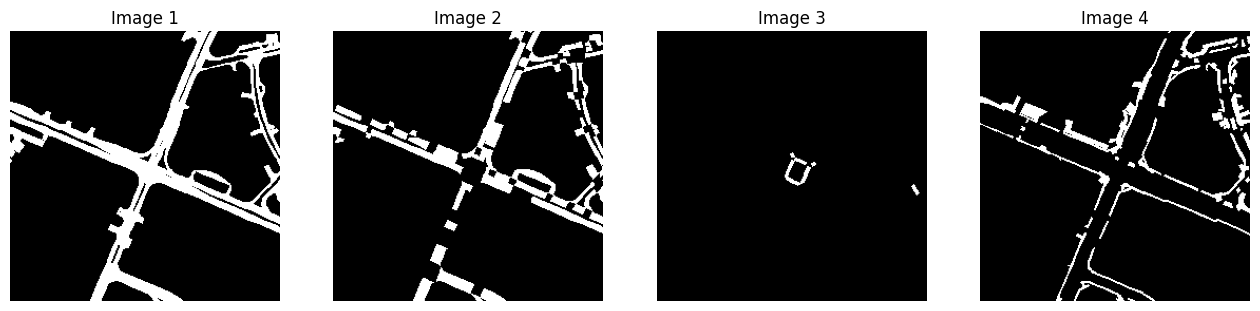

sd_nuscenes_v1.0-trainval_scene-0007.npy


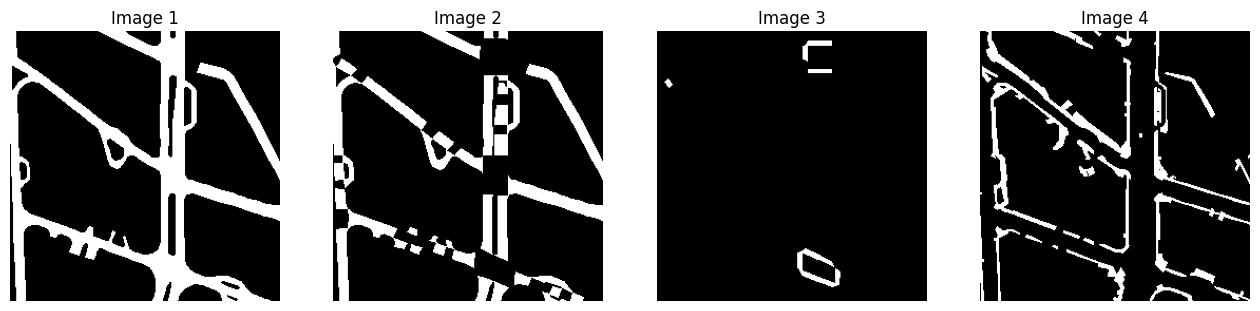

sd_nuscenes_v1.0-trainval_scene-0010.npy


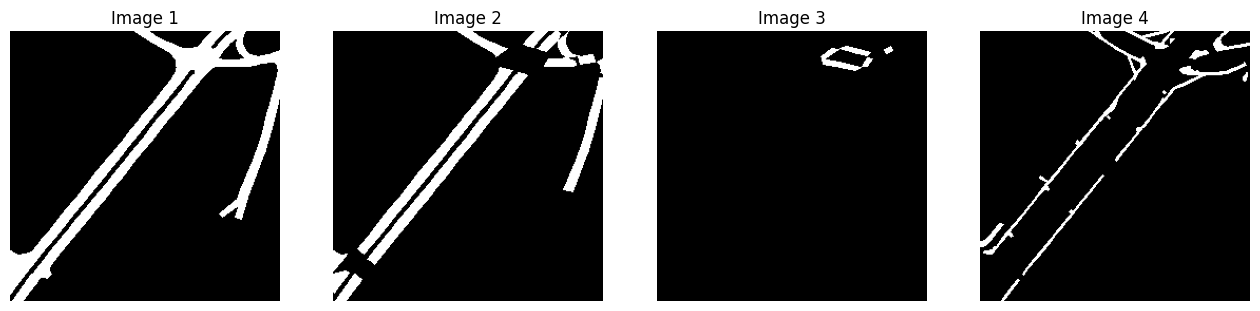

sd_nuscenes_v1.0-trainval_scene-0013.npy


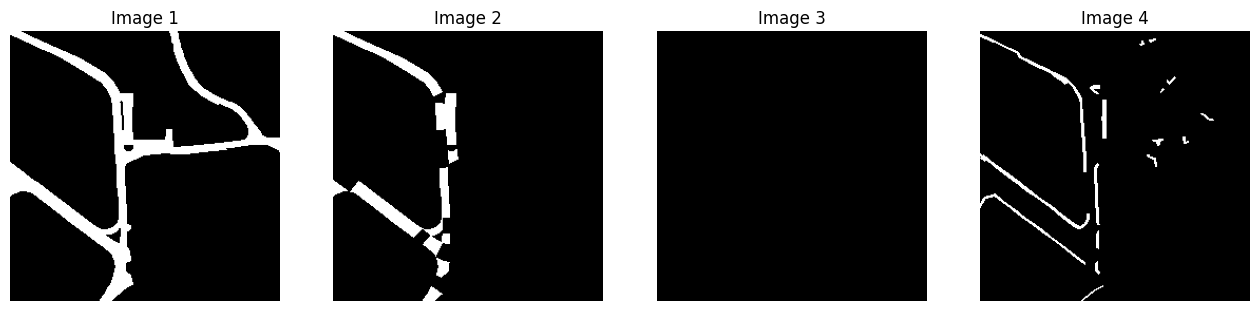

sd_nuscenes_v1.0-trainval_scene-0014.npy


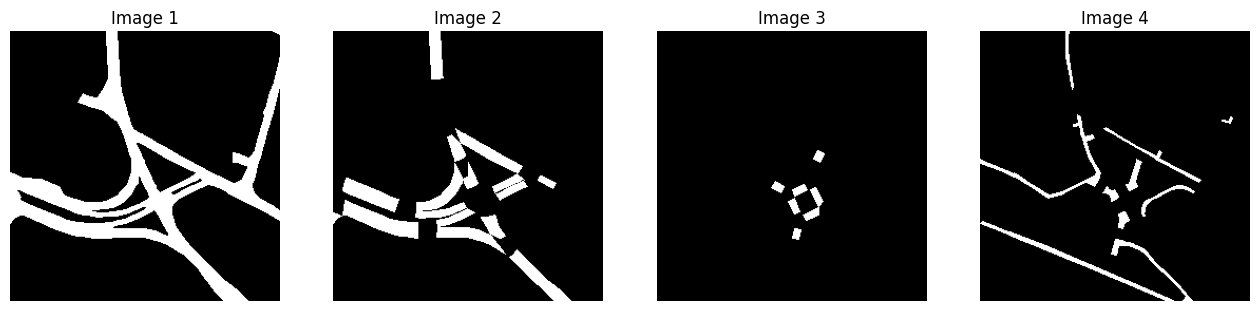

sd_nuscenes_v1.0-trainval_scene-0015.npy


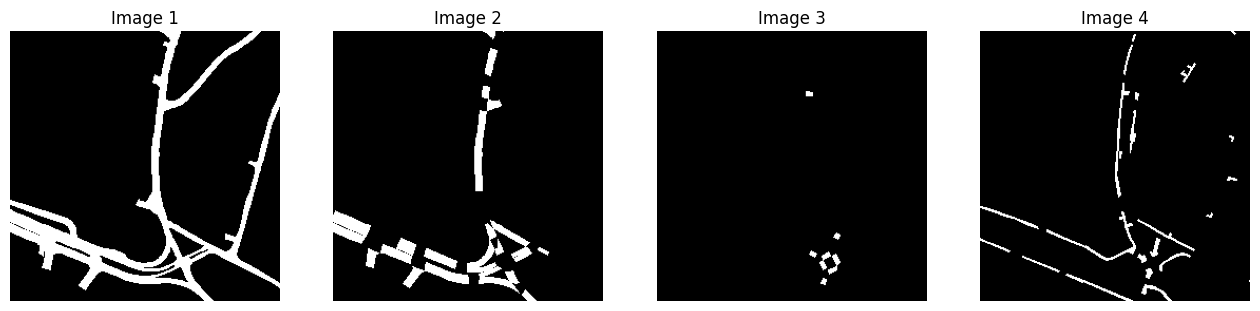

sd_nuscenes_v1.0-trainval_scene-0018.npy


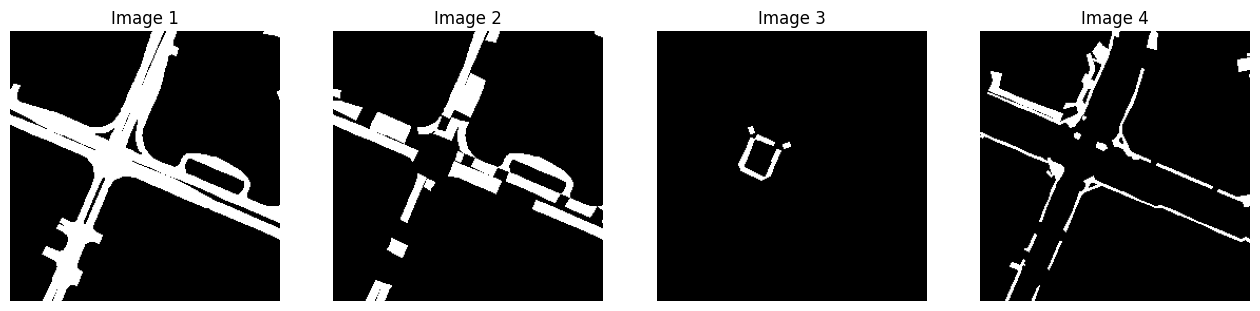

sd_nuscenes_v1.0-trainval_scene-0019.npy


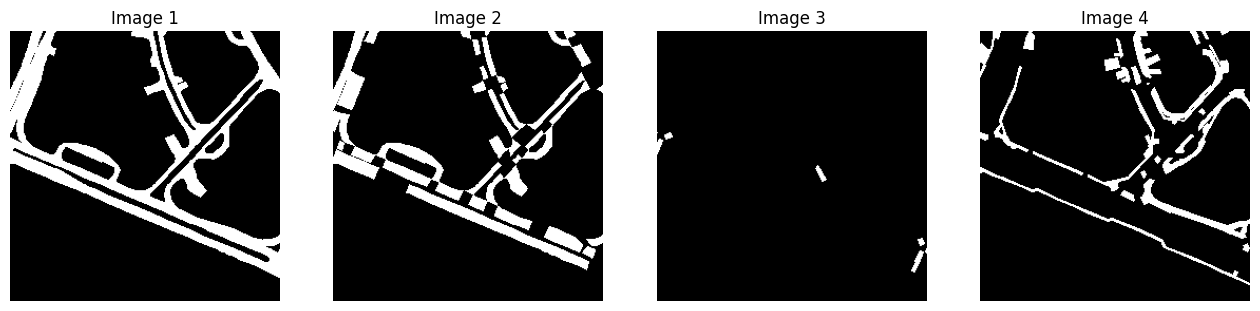

sd_nuscenes_v1.0-trainval_scene-0020.npy


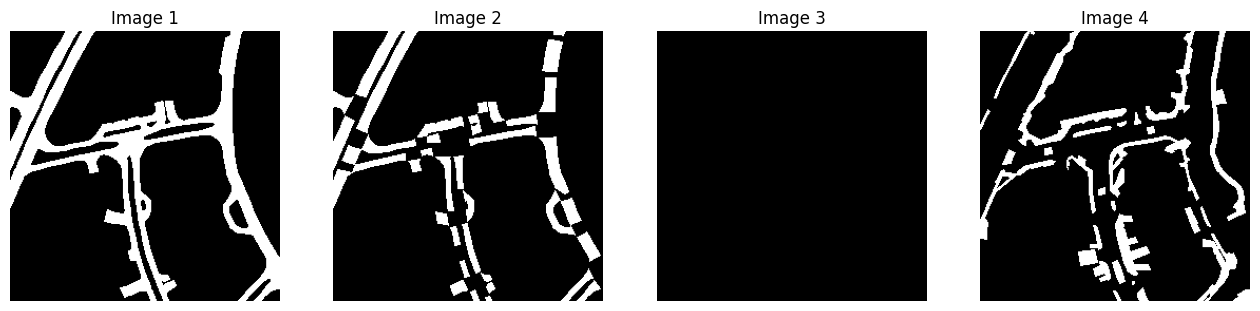

sd_nuscenes_v1.0-trainval_scene-0022.npy


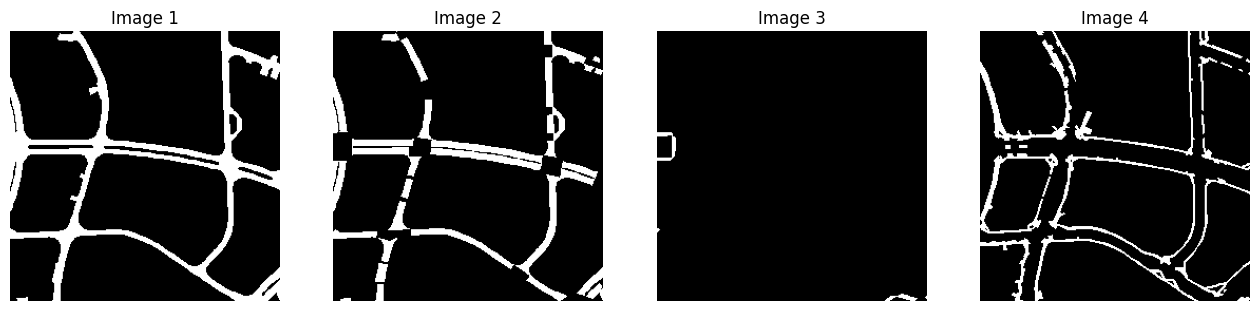

In [ ]:
map_dir = '/data/tii/data/nuscenes_maps/nuscenes_trainval_raster_test'

for l in sorted(os.listdir(map_dir))[:10]:
    print(l)
    data = np.load(os.path.join(map_dir, l))
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i in range(4):
        axes[i].imshow(data[i], cmap='gray')  # Plot each slice in grayscale
        axes[i].set_title(f'Image {i+1}')  # Set title for each subplot
        axes[i].axis('off')  # Turn off axis labels and ticks

    plt.show()  # Display the plots

##### Replace padded values with saturation

In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def replace_padded_values(data):
    """Replace padded values (0.0) with the first next or previous non-zero (x, y) values."""
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # If current value is zero, find the next or previous non-zero value
            if np.all(data[i, j] == 0):
                # Find next non-zero value
                k = j + 1
                while k < data.shape[1] and np.all(data[i, k] == 0):
                    k += 1
                
                if k < data.shape[1]:
                    data[i, j] = data[i, k]
                else:
                    # If no next non-zero value, find the previous non-zero value
                    k = j - 1
                    while k >= 0 and np.all(data[i, k] == 0):
                        k -= 1
                    
                    if k >= 0:
                        data[i, j] = data[i, k]
    
    return data

def process_grouped_npy_files(input_directory, output_directory):
    """Process each grouped npy file to replace padded values and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        modified_data = replace_padded_values(data)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, modified_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_veh_norm_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_veh_norm_satur_npy'

    process_grouped_npy_files(input_directory, output_directory)

if __name__ == "__main__":
    main()

##### Add padding to seq length

In [ ]:
# Define paths
input_directory = '/data/tii/data/nuscenes_trainval_veh_processed_maxag_npy'
output_directory = '/data/tii/data/nuscenes_trainval_veh_final_npy'
os.makedirs(output_directory, exist_ok=True)

# Define the desired sequence length after padding
desired_length = 20

# Function to pad sequences
def pad_sequence(sequence, pad_len, position):
    """
    Pad a sequence to the desired length.
    
    Args:
        sequence (np.ndarray): The original sequence of shape (L, D).
        pad_len (int): The total length to pad the sequence to.
        position (str): Where to add padding. Options are 'beginning', 'middle', 'end', or 'beginning_end'.
    
    Returns:
        np.ndarray: The padded sequence of shape (pad_len, D).
    """
    original_length = sequence.shape[0]
    pad_amount = pad_len - original_length
    pad_before = 0
    pad_middle = 0
    pad_after = 0
    
    if position == 'beginning':
        pad_before = pad_amount
    elif position == 'middle':
        pad_middle = pad_amount
    elif position == 'end':
        pad_after = pad_amount
    elif position == 'beginning_end':
        pad_before = pad_amount // 2
        pad_after = pad_amount - pad_before
    else:
        raise ValueError("Invalid position argument. Choose from 'beginning', 'middle', 'end', 'beginning_end'.")

    padding_before = np.zeros((pad_before, sequence.shape[1]))
    padding_middle = np.zeros((pad_middle, sequence.shape[1]))
    padding_after = np.zeros((pad_after, sequence.shape[1]))
    
    padded_sequence = np.vstack((padding_before, sequence[:sequence.shape[0]//2, :], padding_middle, sequence[sequence.shape[0]//2:, :], padding_after))
    return padded_sequence

# Loop through each file in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        
        # Load the data
        data = np.load(file_path)
        
        # Initialize the padded data array
        padded_data = np.zeros((data.shape[0], desired_length, data.shape[2]))
        
        for i in range(data.shape[0]):
            # Decide where to add padding ('beginning', 'middle', 'end', 'beginning_end')
            positions = ['beginning', 'middle', 'end', 'beginning_end']
            pos = positions[i % len(positions)]  # For illustration, cycle through the positions
            
            padded_data[i] = pad_sequence(data[i], desired_length, pos)
        
        # Save the padded data
        output_path = os.path.join(output_directory, filename)
        np.save(output_path, padded_data)

print("Padding completed and saved to the output directory.")


In [ ]:
import os
import shutil

def move_matching_files(dir_A, dir_B, dir_D):
    """
    Move files from dir_A to dir_D where the filenames match those in dir_B.

    Parameters:
    dir_A (str): The source directory from which to move files.
    dir_B (str): The reference directory to check for matching filenames.
    dir_D (str): The destination directory where files will be moved.
    """

    # Ensure the destination directory exists
    os.makedirs(dir_D, exist_ok=True)

    # Get the set of filenames in dir_B
    files_in_B = set(os.listdir(dir_B))

    # Iterate over files in dir_A
    for filename in os.listdir(dir_A):
        if filename in files_in_B:
            # If a matching file is found, construct full paths
            source_path = os.path.join(dir_A, filename)
            destination_path = os.path.join(dir_D, filename)

            # Move the file from dir_A to dir_D
            shutil.move(source_path, destination_path)
            print(f"Moved: {filename} from {dir_A} to {dir_D}")

if __name__ == "__main__":
    dir_A = '/data/tii/data/nuscenes_maps/nuscenes_trainval_raster'  
    dir_B = '/data/tii/data/nuscenes_trainval_clean_test'  
    dir_D = '/data/tii/data/nuscenes_maps/nuscenes_trainval_raster_test'  

    move_matching_files(dir_A, dir_B, dir_D)


In [ ]:
import os

def rename_files(dir_a, dir_b, dir_c):
    # Get sorted list of files from both directories
    files_a = sorted(os.listdir(dir_a))
    files_b = sorted(os.listdir(dir_b))

    # Check if both directories have the same number of files
    if len(files_a) != len(files_b):
        print("Error: The number of files in both directories must be the same.")
        return

    # Rename files in directory B using names from directory A
    for file_a, file_b in zip(files_a, files_b):
        # Get full paths
        path_a = os.path.join(dir_a, file_a)
        path_b = os.path.join(dir_b, file_b)
        
        # Determine the new name for the file in B
        destination_path = os.path.join(dir_c, file_a)
        shutil.move(path_b, destination_path)
        
        # Moved the renamed file in C
        print(f"Renamed {file_b} to {file_a}")

# Example usage
dir_a = '/data/tii/data/nuscenes_trainval_npy'
dir_b = '/data/tii/data/nuscenes_maps/nuscenes_trainval_raster_npy_copy'
dir_c = '/data/tii/data/nuscenes_maps/nuscenes_trainval_raster'

os.makedirs(dir_c, exist_ok=True)
rename_files(dir_a, dir_b, dir_c)

In [ ]:
# Paths to your dataset
input_directory = '/data/tii/data/nuscenes_trainval_clean_train'

# Step 1: Determine the maximum, minimum, second minimum, and third minimum N
max_N = 0
min_N = float('inf')
unique_N = set()  # To store unique N values

for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        data = np.load(file_path)
        N, L, D = data.shape
        # Update max and min N
        max_N = max(max_N, N)
        min_N = min(min_N, N)
        # Store the unique N values
        unique_N.add(N)

# Convert the set of unique N values to a sorted list
sorted_N = sorted(unique_N)

# Get the second and third minimum if they exist
second_min_N = sorted_N[1] if len(sorted_N) > 1 else None
third_min_N = sorted_N[2] if len(sorted_N) > 2 else None

# Get the second and third maximum if they exist
second_max_N = sorted_N[-2] if len(sorted_N) > 1 else None
third_max_N = sorted_N[-3] if len(sorted_N) > 2 else None

print(f"Maximum number of agents (N) across all files: {max_N}")
print(f"Second maximum number of agents (N): {second_max_N}")
print(f"Third maximum number of agents (N): {third_max_N}")

print(f"Minimum number of agents (N) across all files: {min_N}")
print(f"Second minimum number of agents (N): {second_min_N}")
print(f"Third minimum number of agents (N): {third_min_N}")

""" for veh_clean_train and test and test before padding
Maximum number of agents (N) across all files: 19
Second maximum number of agents (N): 15
Third maximum number of agents (N): 14
Minimum number of agents (N) across all files: 1
Second minimum number of agents (N): 2
Third minimum number of agents (N): 3

Maximum number of agents (N) across all files: 9
Second maximum number of agents (N): 8
Third maximum number of agents (N): 7
Minimum number of agents (N) across all files: 1
Second minimum number of agents (N): 2
Third minimum number of agents (N): 3
"""

In [ ]:
# Paths to your dataset
input_directory = '/data/tii/data/nuscenes_trainval_update'
output_directory = '/data/tii/data/nuscenes_trainval'
os.makedirs(output_directory, exist_ok=True)

max_N = 49
# Step 2: Pad each file to max_N
for filename in os.listdir(input_directory):
    if filename.endswith('.npy'):
        file_path = os.path.join(input_directory, filename)
        data = np.load(file_path)
        N, L, D = data.shape
        
        if N < max_N:
            # Create a new array with the shape (max_N, L, D) and fill it with zeros
            padded_data = np.zeros((max_N, L, D))
            
            # Copy the original data into the new array
            padded_data[:N, :, :] = data
            
            # Save the padded data
            output_path = os.path.join(output_directory, filename)
            np.save(output_path, padded_data)
        else:
            # If no padding is needed, just copy the original file to the output directory
            output_path = os.path.join(output_directory, filename)
            np.save(output_path, data)

print("Padding completed and saved to the output directory.")

In [ ]:
import os
import numpy as np

def remove_stationary_agents(data, min_distance=0.7):
    """
    Remove stationary agents from a dataset while ignoring padded data.

    Parameters:
        data (numpy.ndarray): A dataset containing trajectories of agents.
                              Expected shape is (N, L, D) where N is the number of agents,
                              L is the sequence length, and D is the dimension (e.g., x, y positions).
        min_distance (float): The minimum total distance an agent must move to not be considered stationary.

    Returns:
        numpy.ndarray: A new dataset with stationary agents removed.
    """
    # Split data into history and future parts
    data_history = data[:, :8, :]  # Shape: (N, 8, D)
    data_future = data[:, 8:, :]   # Shape: (N, L-8, D)

    # Calculate total movement for history part
    non_padded_mask_history = ~(np.all(data_history == 0., axis=2))
    diffs_history = np.diff(data_history, axis=1)
    valid_diffs_mask_history = non_padded_mask_history[:, :-1] & non_padded_mask_history[:, 1:]
    valid_diffs_history = diffs_history * valid_diffs_mask_history[:, :, np.newaxis]
    distances_history = np.linalg.norm(valid_diffs_history, axis=2)
    total_movement_history = distances_history.sum(axis=1)

    # Calculate total movement for future part
    non_padded_mask_future = ~(np.all(data_future == 0., axis=2))
    diffs_future = np.diff(data_future, axis=1)
    valid_diffs_mask_future = non_padded_mask_future[:, :-1] & non_padded_mask_future[:, 1:]
    valid_diffs_future = diffs_future * valid_diffs_mask_future[:, :, np.newaxis]
    distances_future = np.linalg.norm(valid_diffs_future, axis=2)
    total_movement_future = distances_future.sum(axis=1)

    # Identify non-stationary agents in both history and future
    non_stationary_agents = (total_movement_future > min_distance) & (total_movement_history > min_distance)

    # Filter out the stationary agents
    filtered_data = data[non_stationary_agents]

    return filtered_data


def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]


def process_grouped_npy_files(input_directory, output_directory, min_distance):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        filtered_data = remove_stationary_agents(data, min_distance=min_distance)
        if filtered_data.shape[0] != 0:  # Only save non-empty filtered data
            output_path = os.path.join(output_directory, os.path.basename(file_path))
            np.save(output_path, filtered_data)
            print(f"Processed and saved {output_path}")
            print(f"Shape of filtered data {filtered_data.shape}")
        else:
            print(f"No non-stationary agents found in {file_path}")


def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update'
    process_grouped_npy_files(input_directory, output_directory, min_distance=0.4)


if __name__ == "__main__":
    main()


In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def process_grouped_npy_files(input_directory, output_directory, scale_factor):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        scaled_data = data * scale_factor
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, scaled_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'

    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, scale_factor=100)

if __name__ == "__main__":
    main()

In [ ]:
import os
import numpy as np

def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def calculate_mean_std_excluding_padding(input_directory):
    """Calculate the mean and standard deviation for x and y positions across all files, excluding zero padding."""
    npy_files = list_npy_files(input_directory)
    all_non_zero_values = []

    for file_path in npy_files:
        data = np.load(file_path)
        # Mask out the zero-padded values
        mask = np.any(data != 0, axis=-1)  # Assuming D=2 for x, y
        non_zero_data = data[mask]
        all_non_zero_values.append(non_zero_data)

    all_non_zero_values = np.concatenate(all_non_zero_values, axis=0)  # Combine all non-zero data
    print(all_non_zero_values.shape)
    mean = np.mean(all_non_zero_values, axis=0)
    std = np.std(all_non_zero_values, axis=0)
    return mean, std

def calculate_mean_std(input_directory):
    """Calculate the mean and standard deviation for x and y positions across all files."""
    npy_files = list_npy_files(input_directory)
    all_data = []

    for file_path in npy_files:
        data = np.load(file_path)
        all_data.append(data)

    all_data = np.concatenate(all_data, axis=0)
    mean = np.mean(all_data, axis=(0, 1))
    std = np.std(all_data, axis=(0, 1))
    return mean, std

def normalize_and_standardize_excluding_padding(data, mean, std):
    """Normalize and standardize the positions x and y in the data, excluding zero padding."""
    mask = np.any(data != 0, axis=-1)
    normalized_standardized_data = np.copy(data)
    normalized_standardized_data[mask] = (data[mask] - mean) / std
    return normalized_standardized_data

def process_grouped_npy_files(input_directory, output_directory, mean, std):
    """Process each grouped npy file to normalize and standardize the positions and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        normalized_standardized_data = normalize_and_standardize_excluding_padding(data, mean, std)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, normalized_standardized_data)
        print(f"Processed and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'
    
    mean, std = calculate_mean_std_excluding_padding(input_directory)
    print(f'Calculate mean and std while considering padded values: (mean: {mean}, std: {std})')
    
    #mean, std = calculate_mean_std(input_directory)
    #print(f'Calculate mean and std without considering padded values: (mean: {mean}, std: {std})')

    # Process files to normalize and standardize
    process_grouped_npy_files(input_directory, output_directory, mean, std)

if __name__ == "__main__":
    main()


In [ ]:
def list_npy_files(directory):
    """List all .npy files in the specified directory."""
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.npy')]

def process_npy_files(input_directory, output_directory, step=12):
    """Process each grouped npy file to replace padded values and save the modified files."""
    os.makedirs(output_directory, exist_ok=True)
    npy_files = list_npy_files(input_directory)

    for file_path in npy_files:
        data = np.load(file_path)
        output_path = os.path.join(output_directory, os.path.basename(file_path))
        np.save(output_path, data[:, ::step, :])
        print(f"Cropped, sampled, and saved {output_path}")

def main():
    input_directory = '/data/tii/data/nuscenes_trainval_npy'
    output_directory = '/data/tii/data/nuscenes_trainval_update_npy'

    process_npy_files(input_directory, output_directory, step=12)

if __name__ == "__main__":
    main()